In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Image
import math
import pickle
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec

In [2]:
# load data. 
# eid_data (POB, POR, GridIDs, NUTS3_IDs)
eid_data = pd.read_csv('../00_csv_files/eid_data.csv')
# grid coordinates; 10k grid centroids and ids
grid = pd.read_csv('../00_csv_files/10km_grid_with_ukb_points.csv')
# assessment centers
acc = pd.read_csv('../00_csv_files/assessmentCentreCoordinates.csv')
# POB-POR movement
pob_por_migration = pd.read_csv('../00_csv_files/pob_por_migration.csv')

In [3]:
# phenotypes
pheno_cat = pd.read_csv('../00_csv_files/pheno_cat.csv')
pheno_strat = pd.read_csv('../00_csv_files/pheno_strat.csv')
pheno_int = pd.read_csv('../00_csv_files/pheno_int.csv')
pheno_cont = pd.read_csv('../00_csv_files/pheno_cont.csv')

In [4]:
# functions
def get_ncolors_from_cmap(num_colors,colormap='viridis'):
    cmap = cm.get_cmap(colormap)
    cols = [cmap(x) for x in np.linspace(0,1,num_colors)]
    return cols

# dictionaries for movers and stayers: centerIDs => list of eids
def get_stayers_movers(pob_por_migration, movement_threshold):
    movers = {}
    stayers = {}
    
    pob_por_distance = dict(zip(pob_por_migration.eid,pob_por_migration.distances))

    for ac in acc.Code.tolist():
        movers[ac] = []
        stayers[ac] = []
        eid_list_ac = eid_data[eid_data.center == ac]['eid'].tolist()
        for eid in eid_list_ac:
            if pob_por_distance[eid] > movement_threshold:
                movers[ac].append(eid)
            else:
                stayers[ac].append(eid)
    return stayers, movers

def get_summary_data(vec):
    # get total number, mean value for data in a vector of lists
    lengths = [len(x) for x in vec]
    total_datapoints = np.sum(lengths)
    means = [np.nanmean(x) for x in vec]
    overall_mean = np.nanmean(means)
    return overall_mean, total_datapoints

# add columns for allStayersAllMovers.npy (all Data) and for lastGenData.npy
def add_summary_columns(a):
    num_rows, num_cols = np.shape(a)
    empty = np.zeros([num_rows,4])
    with_data_added = np.hstack([a,empty])
    allData = np.load('../06_AC_phenotype_matrix_data/allStayersAllMovers.npy')[:,2]
    lastGen = np.load('../06_AC_phenotype_matrix_data/lastGenData.npy')[:,2]
    with_data_added[:,num_cols+1] = allData
    with_data_added[:,num_cols+3] = lastGen
    return with_data_added

In [5]:
# make dictionary: phenotypes => what file they are from (and what type they are)
pheno_type = {}
cats = pheno_cat.columns.tolist()[1:]
for c in cats:
    pheno_type[c] = 'cat'
strats = pheno_strat.columns.tolist()[1:]
for s in strats:
    pheno_type[s] = 'strat'
ints = pheno_int.columns.tolist()[1:]
for i in ints:
    pheno_type[i] = 'int'
conts = pheno_cont.columns.tolist()[1:]
for co in conts:
    pheno_type[co] = 'cont'

In [6]:
# stayers & movers dictionaries: assessment center => list of eids
stayers, movers = get_stayers_movers(pob_por_migration, 20000)

# dataframe of movers and stayers for assessment centers
acList = sorted(list(movers.keys()))
numMove = [len(movers[x]) for x in acList]
numStay = [len(stayers[x]) for x in acList]
acNames = dict(zip(acc.Code,acc.Name))

propMove = [n / np.sum([n,numStay[i]]) for i,n in enumerate(numMove)]
names = [acNames[x] for x in acList]

d = {'name':names, 'ac_code': acList, 'num_movers': numMove, 'num_stayers': numStay, 'proportion_moved': propMove}
ac_movers_stayers = pd.DataFrame(d)
ac_movers_stayers

,name,ac_code,num_movers,num_stayers,proportion_moved
0,Manchester,11001,4640,7266,0.389719
1,Oxford,11002,8728,3152,0.734680
2,Cardiff,11003,7214,9239,0.438461
3,Glasgow,11004,4137,13058,0.240593
4,Edinburgh,11005,7932,7633,0.509605
5,Stoke,11006,6818,11538,0.371432
6,Reading,11007,20923,4868,0.811252
7,Bury,11008,7939,17515,0.311896
8,Newcastle,11009,10045,24944,0.287090
9,Leeds,11010,16575,24402,0.404495


In [7]:
# show plots and make phenotype vector for this phenotype
def plot_save_ac_pheno_data(phenoCol, pheno_type, pob_por_migration, moveThreshold, plotAll=True):

    # get movers and stayers
    stayers, movers = get_stayers_movers(pob_por_migration, moveThreshold)
    
    # Make dictionary: eid => phenotype of interest
    dtype = pheno_type[phenoCol]
    df = pd.read_csv('../00_csv_files/pheno_' + dtype + '.csv')
    phenotypes = dict(zip(df.eid,df[phenoCol]))

    # Make dictionaries of phenotype values for movers and stayers keyed by assessment center
    mover_phenotypes = {}
    stayer_phenotypes = {}

    for ac in sorted(movers.keys()):
        move_phenotype_list = [phenotypes[x] for x in movers[ac] if x in phenotypes.keys()]
        stay_phenotype_list = [phenotypes[x] for x in stayers[ac] if x in phenotypes.keys()]

        # filter phenotypes to exclude negative values
        move_phenotype_list = [x for x in move_phenotype_list if x >= 0]
        stay_phenotype_list = [x for x in stay_phenotype_list if x >= 0]          

        # had lots of other filters here, but recoded source data instead
        # see http://localhost:8888/notebooks/recode_phenos.ipynb
        
        # assign lists to dictionaries
        mover_phenotypes[ac] = move_phenotype_list
        stayer_phenotypes[ac] = stay_phenotype_list

    # get data for all assessment centers  
    m = []
    for ac in mover_phenotypes.keys():
        m.append(stayer_phenotypes[ac])
        m.append(mover_phenotypes[ac])
    
    # get summary values for this phenotype
    # mean_stayers, mean_movers, percDiff, n_stayers, n_movers
    m = np.array(m)
    stayIndices = np.arange(0,len(m),2)
    moveIndices = stayIndices + 1
    
    stayData = m[stayIndices]
    mean_stayers, n_stayers = get_summary_data(stayData)
    
    moveData = m[moveIndices]
    mean_movers, n_movers = get_summary_data(moveData)
    
    percDiff = (mean_movers - mean_stayers) / float(mean_stayers)
    
    summaryVals = [mean_stayers, mean_movers, percDiff, n_stayers, n_movers]
    #print(summaryVals)
    
    # plot for all assessment centers
    f,a = plt.subplots(1,1,figsize=(18,4))
    a.boxplot(m,showfliers=False)
    a.set_ylabel(phenoCol,fontsize=12)

    xlab_pos = np.arange(1.5,len(m)+0.5,2)
    divider_pos = xlab_pos[:-1] + 1
    xlabs = [acNames[x] for x in acList]

    # partition lines
    yrange = a.get_ylim()
    for dx in divider_pos:
        a.plot([dx,dx],yrange,color='lightgray',linewidth=1)

    a.set_title('stayers-movers for assessment centers')

    plt.xticks(xlab_pos, xlabs, rotation=90, fontsize = 12)

    fstem = '../06_AC_phenotype_matrix_data/' + phenoCol.replace(' ','_')
    plt.savefig(fstem + '_assessment_centers.png', format = 'png')

    # save the raw data matrix and summary values
    np.save(fstem + '_assessment_centers_data.npy', np.hstack([summaryVals,m]))

    if plotAll == True:
        plt.show()

    # summary plot for all movers & stayers
    all_movers = pob_por_migration[pob_por_migration.distances>moveThreshold].eid.tolist()
    all_stayers = pob_por_migration[pob_por_migration.distances<=moveThreshold].eid.tolist()
    eidGroups = [all_stayers,all_movers]
    grouplabels = ['stayers','movers']

    m_to_plot = []
    for i, g in enumerate(eidGroups):
        # collect data in a column
        d = df[df['eid'].isin(g)][phenoCol].values
        # ... remove NaN
        d_with_data = d[~np.isnan(d)] 
        # ... remove negative numbers
        d_pos = d_with_data[np.where(d_with_data>=0)]
        
        if plotAll == True:
            print(grouplabels[i], '=  all: ', len(d),'; with data: ', len(d_with_data),'; with positive values: ',len(d_pos))
        m_to_plot.append(d_pos)

    if pheno_type[phenoCol] == 'cat' or pheno_type[phenoCol] == 'strat':
        plotType = 'stacked'
    else:
        plotType = 'boxes'

    if plotType == 'boxes':
        # integer or continuous data: plot as boxplots (or violinplots)
        fig, ax = plt.subplots(1,1,figsize=(4,6))

        ax.boxplot(m_to_plot,showfliers=False)
        #ax.boxplot(m_to_plot)
        #ax.violinplot(m_to_plot)
        ax.set_xticks([1,2])
        ax.set_xticklabels(grouplabels,fontsize=16)
        ax.set_title(phenoCol,fontsize=16)
        
        if plotAll == True:
            print('numbers: ',' '.join(str(y) for y in [len(x) for x in m_to_plot]))
            print('means: ', '  '.join(['{:01.2f}'.format(y) for y in [np.mean(x) for x in m_to_plot]]))

    elif plotType =='stacked':
        fig,(ax,ax2) = plt.subplots(1,2,figsize=(14,8))

        # total number of categories
        n = np.unique(df[phenoCol])
        n = n[~np.isnan(n)]
        n = n[np.where(n>=0)]
        numCats = len(n)

        plotVals = []
        cols = get_ncolors_from_cmap(numCats,colormap='jet')

        table_for_stats = []

        for i,m in enumerate(m_to_plot):
            labels, counts = np.unique(m, return_counts=True)
            percentages = [x/np.sum(counts)*100 for x in counts]
            table_for_stats.append(counts)
            bot = 0
            for j,p in enumerate(percentages):
                ax.bar(i+1, p , align='center', bottom=bot, color=cols[j])
                bot = bot + p

        ax.set_ylabel('percentage',fontsize=16)
        ax.set_xticks([1,2])
        ax.set_xticklabels(grouplabels,fontsize=16)
        ax.set_title(phenoCol,fontsize=16)

        fname = phenoCol + '.png'
        img=mpimg.imread('../05_pheno_codes/' + fname)
        ax2.imshow(img)
        ax2.set_axis_off()
        
        if plotAll == True:
            print('numbers:\t','\t'.join(str(y) for y in [len(x) for x in m_to_plot]))

    plt.savefig(fstem + '_movers_stayers.png', format = 'png')
    
    if plotAll == True:
        plt.show()
    else:
        plt.close('all')

In [8]:
# record data and save plots for all phenotypes
# for p in pheno_type.keys():
#     print(p)
#     plot_save_ac_pheno_data(p, pheno_type, pob_por_migration, 20000, plotAll=False) 
#     # Noisy workplace gives a RuntimeWarning: Mean of empty slice
    
#plot_save_ac_pheno_data('Able to confide', pheno_type, pob_por_migration, 20000, plotAll=True) 
# #print(pheno_type)

In [8]:
# make matrix for heatmap

path = '../06_AC_phenotype_matrix_data/'
phe = open(path + 'phenotypes_to_include_on_matrix.csv','r').readlines()
phe = [p.rstrip() for p in phe]

ac_phenotype_matrix = np.zeros([len(phe),len(acList)])
summary_values = np.zeros([len(phe),5])

pheNames = []

for j,p in enumerate(phe):
    pstem = p.rstrip().replace(' ','_') 
    pheNames.append(pstem)
    fname = path + pstem + '_assessment_centers_data.npy'
    
    summaryVals_and_d = np.load(fname)
    #print(p)
    summary_values[j,:] = summaryVals_and_d[:5]
    d = summaryVals_and_d[5:]
    
    # from matrix, make vector of %mov for each pair of columns (stay,move)
    stayIndices = np.arange(0,len(d),2)
    
    percVec = np.zeros(int(len(d)/2.0))
    
    for i,s in enumerate(stayIndices):
        # d[s] is usually a list
        # but sometimes it can be a single float
        # and sometimes it can be an nan ... which causes runtime errors
        stayvals = np.nanmean(d[s])
        movevals = np.nanmean(d[s+1])
        percdiff = (movevals - stayvals) / float(stayvals) * 100
        percVec[i] = percdiff
        
    ac_phenotype_matrix[j,:] = percVec
    
# problems with this:
# 'Number of self-reported cancers' gives mean of empty slice warning

/Users/iwoods/p3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/Users/iwoods/p3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


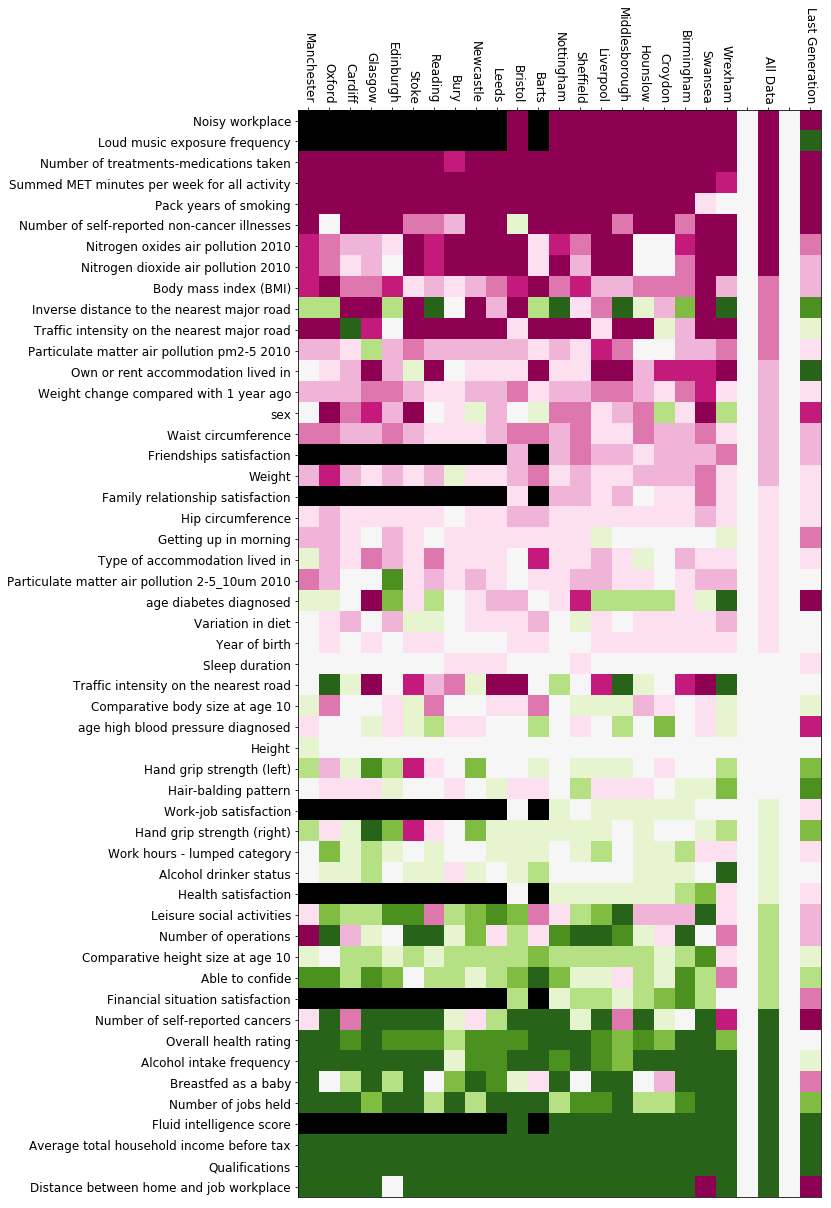

In [9]:
# plot the heatmap
addSummaryData = True # add columns for allStayersAllMovers.npy (all Data) and for lastGenData.npy
f= plt.figure(figsize=(12,20))

if addSummaryData == True:
    ac_phenotype_matrix = add_summary_columns(ac_phenotype_matrix)
    
    # sort by average of all data
    sortInd = ac_phenotype_matrix[:,-3].argsort()
    ac_phenotype_matrix = ac_phenotype_matrix[sortInd]
    phe = np.array(phe)
    phe = phe[sortInd]

# want to make nan values black in image ... save their locations here
nans = np.where(np.isnan(ac_phenotype_matrix))

# adjust the levels of the ac_phenotype_matrix to a smaller scale based on perc_thresholds
perc_thresholds = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
#perc_thresholds = perc_thresholds * 2
cmap_levels = np.linspace(0,1,len(perc_thresholds))
leveled_matrix = np.zeros(np.shape(ac_phenotype_matrix))

for i,c in enumerate(cmap_levels):
    if i == 0:
        #leveled_matrix[np.where(ac_phenotype_matrix < perc_thresholds[i])] = cm
        leveled_matrix[np.less(ac_phenotype_matrix, perc_thresholds[i],
                               where=~np.isnan(ac_phenotype_matrix))] = c
    elif i == len(cmap_levels)-1:
        #leveled_matrix[np.where(ac_phenotype_matrix >= perc_thresholds[i])] = cm
        leveled_matrix[np.greater_equal(ac_phenotype_matrix, perc_thresholds[i], 
                                        where=~np.isnan(ac_phenotype_matrix))] = c
    else:
        leveled_matrix[np.where(np.logical_and(np.greater_equal(ac_phenotype_matrix,perc_thresholds[i],
                                                                where=~np.isnan(ac_phenotype_matrix)),
                                               np.less(ac_phenotype_matrix,perc_thresholds[i+1],
                                                       where=~np.isnan(ac_phenotype_matrix))))] = c

# convert the nan spots back to nan
leveled_matrix[nans] = np.nan

gs = GridSpec(1, 20, figure=f)

# heat map
masked_array = np.ma.array(leveled_matrix, mask=np.isnan(leveled_matrix))
xlabs = [acNames[x] for x in acList]   

if addSummaryData == True:
    xlabs.extend(['','All Data','','Last Generation'])
    a = f.add_subplot(gs[:,:])
else:
    a = f.add_subplot(gs[:,:14])
    a2 = f.add_subplot(gs[:,14:])

plt.sca(a)    
cmap = cm.PiYG
cmap.set_bad('black',1.)
plt.imshow(masked_array, interpolation='nearest', cmap=cmap)

a.xaxis.tick_top()
a.xaxis.set_label_position('top') 
xlab_pos = np.arange(0,np.shape(masked_array)[1])
 
plt.xticks(xlab_pos,xlabs,rotation=-90,fontsize=12)

ylab_pos = np.arange(0,np.shape(ac_phenotype_matrix)[0])
plt.yticks(ylab_pos, phe, fontsize=12)

if addSummaryData == False:
    # with labels and numbers (means, percDiff, etc) on right
    plt.sca(a2)
    a2.xaxis.tick_top()
    a2.xaxis.set_label_position('top') 
    #xlab_pos = [0,1,2,3,4]
    #xlabs = ['µ movers','µ stayers','Percent Diff','n movers','n stayers']
    xlabs = ['Percent Diff','n movers','n stayers']
    xlab_pos = [0,1,2]
    a2.set_xlim([xlab_pos[0] - 0.5, xlab_pos[-1] + 0.5])
    a2.set_ylim([-0.3,np.shape(summary_values)[0]-0.3])
    plt.xticks(xlab_pos,xlabs,rotation=-90,fontsize=12)
    plt.yticks([])

    sv = np.flipud(summary_values)
    for i in np.arange(np.shape(sv)[0]):
        plt.text(-0.3,i,'{:1.2f}'.format(sv[i,2]*100) + '%')
        plt.text(0.7,i,str(int(sv[i,3])))
        plt.text(1.7,i,str(int(sv[i,4])))

plt.show()

# hierarchical clustering / dendogram on binned / categorical data

In [15]:
print(perc_thresholds)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]


In [10]:
# looking at one phenotype
phenoCol = 'Height'
s = phe.index(phenoCol)

f = plt.figure(figsize=(16,3))
plt.imshow(masked_array[s:s+1,:],interpolation='nearest',cmap = cm.PiYG, vmin=0, vmax=1)
plt.axis('off')
plt.show()

# get values for one phenotype
fname = phenoCol.replace(' ','_') + '_assessment_centers_data.npy'
sd = np.load('../06_AC_phenotype_matrix_data/' + fname)
d = sd[5:]
s = sd[:5]

# from matrix, make vector of %mov for each pair of columns (stay,move)
stayIndices = np.arange(0,len(d),2)
percVec = np.zeros(int(len(d)/2.0))

for i,s in enumerate(stayIndices):
    # d[s] is usually a list
    # but sometimes it can be a single float
    # and sometimes it can be an nan ... which causes runtime errors
    stayvals = np.nanmean(d[s])
    movevals = np.nanmean(d[s+1])
    percdiff = (movevals - stayvals) / float(stayvals) * 100
    percVec[i] = percdiff

pv = ['{:02.1f}'.format(x) for x in percVec]    
print(' '.join(pv))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

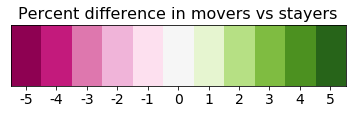

In [84]:
# color key
#perc_thresholds = [-10, -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10]
perc_thresholds = [-5, -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,  5]
cmap_levels = np.linspace(0,1,len(perc_thresholds))
cl = np.vstack([cmap_levels,cmap_levels])
plt.imshow(cl,interpolation='nearest',cmap = cm.PiYG)
plt.yticks([])
xlab_pos = [0,1,2,3,4,5,6,7,8,9,10]
plt.xticks(xlab_pos,perc_thresholds,fontsize=14)
plt.title('Percent difference in movers vs stayers',fontsize=16)
plt.show()

In [38]:
# mean_stayers, mean_movers, percDiff, n_stayers, n_movers
summary_values = np.flipud(summary_values)
for i in np.arange(np.shape(summary_values)[0]):
    print(phe[i], '{:1.2f}'.format(summary_values[i,0]), '{:1.2f}'.format(summary_values[i,1]))

Alcohol intake frequency 3.99 4.25
Body mass index (BMI) 27.82 27.13
Comparative body size at age 10 2.17 2.19
Comparative height size at age 10 2.34 2.33
Current alcohol drinker 0.92 0.94
Gained weight compared with 1 year ago 0.30 0.27
Getting up in morning 3.11 3.11
Hand grip strength (left) 29.55 29.84
Hand grip strength (right) 31.66 32.07
Health satisfaction 4.20 4.26
Hip circumference 103.77 103.16
More than 5 years exposure to loud music 0.05 0.04
More than 5 years exposure to noisy workplace 0.16 0.09
Number of operations 2.23 2.26
Number of self-reported cancers 1.07 1.08
Number of self-reported non-cancer illnesses 2.56 2.46
Number of treatments-medications taken 3.47 3.26
Overall health rating 2.81 2.94
Pack years of smoking 24.92 22.53
Sleep duration 7.14 7.16
Summed MET minutes per week for all activity 2922.98 2550.20
Taller at age 10 0.24 0.28
Thinner at age 10 0.33 0.32
Waist circumference 91.02 89.51
Weight 78.87 77.93
Weight change compared with 1 year ago 2.34 2.37


In [13]:
pheno_cont.head(5)

,eid,Waist circumference,Hip circumference,Pack years of smoking,Body mass index (BMI),Weight,Summed MET minutes per week for all activity,Nitrogen dioxide air pollution 2010,Nitrogen oxides air pollution 2010,Particulate matter air pollution pm2-5 2010,Particulate matter air pollution 2-5_10um 2010,Inverse distance to the nearest major road,height
0,1000015,96.0,89.0,NaN,25.3515,75.0,11358.0,40.57,75.75,NaN,NaN,0.00990,NaN
1,1000027,89.0,106.0,NaN,27.8268,99.4,1830.0,14.40,22.99,8.49,5.91,0.01000,NaN
2,1000039,96.0,115.0,NaN,33.4186,73.2,693.0,35.61,63.43,11.24,6.55,0.00553,NaN
3,1000040,65.0,90.0,31.875,18.3203,58.7,NaN,13.12,19.97,8.17,6.11,0.00048,NaN
4,1000053,70.5,93.0,NaN,18.2969,63.3,5733.0,20.36,28.53,8.96,6.01,0.00110,NaN


In [17]:
len(pheno_cont[pheno_cont['height'] > 0])

8756